In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

In [ ]:
#Need to specify dtype of columns for every csv column for this and every other import

#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]

roster.shape

In [ ]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365.25)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365.25)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=3)

In [4]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [5]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)

In [6]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])


In [7]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [8]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [9]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [10]:
#reads in draft data and the NHL stats of each drafted player and then joins it to the 
#master dataframe
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = roster.fillna(value=0)

In [11]:
roster.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,league,nhl_GP,nhl_G,nhl_A,nhl_TP
0,0,Tommy Albelin,38.32,D,1964-05-21,"Stockholm, SWE",6.08,194,L,701,80,2003,Albany River Rats,2002-09-15,2003-09-15,39.318,21,5,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.40,AHL,0.0,0,0,0
1,3,Daryl Andrews,25.39,D,1977-04-27,"Campbell River, BC, CAN",6.17,205,L,12221,80,2003,Albany River Rats,2002-09-15,2003-09-15,26.385,8,75,3,6,9,52,0,0,0,0,0,0,0.33,0.67,0.12,AHL,0.0,0,0,0
2,7,Alex Brooks,26.07,D,1976-08-21,"Madison, WI, USA",6.08,194,R,10257,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.066,9,66,0,7,7,56,0,0,0,0,0,0,0.00,1.00,0.11,AHL,0.0,0,0,0
3,0,Phil Cole,20.02,D,1982-09-06,"Winnipeg, MB, CAN",6.33,196,L,15899,80,2003,Albany River Rats,2002-09-15,2003-09-15,21.024,3,4,0,0,0,6,0,0,0,0,0,0,0.00,0.00,0.00,AHL,0.0,0,0,0
4,28,Ray Giroux,26.15,D,1976-07-20,"North Bay, ON, CAN",6.08,190,L,12229,80,2003,Albany River Rats,2002-09-15,2003-09-15,27.154,9,67,11,38,49,49,0,0,0,0,0,0,0.22,0.78,0.73,AHL,0.0,0,0,0


In [12]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [13]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [14]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


In [15]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


In [58]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[(roster['draft_year'] == 0)]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [59]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [60]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [61]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [62]:
draft_year_df = pd.get_dummies(draft_year_df, columns=['league'])

In [63]:
draft_year_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
#split draft_year_df into one for forwards and defensemen
draft_2018_df = draft_year_df[draft_year_df['season'] == 2018]
draft_year_df = draft_year_df[draft_year_df['season']<2018]
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [65]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL
25567,47,Filip Andersson,17.75,D,1999-12-14,Smedjebacken HC,6.25,198,L,265669,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.754,0,7,0,0,0,0,3,0,0,0,0,-1,0.00,0.00,0.00,0.0,0.0,0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25569,97,Adam Boqvist,17.08,D,2000-08-15,Hedemora SK,5.92,170,R,265684,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.084,0,7,0,2,2,2,0,0,0,0,0,0,0.00,1.00,0.29,0.0,0.0,0,0.0,0.288794,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25575,71,Jacob Ragnarsson,17.98,D,1999-09-23,SK Iron,6,176,L,304366,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.979,0,47,4,9,13,24,5,0,0,0,6,-1,0.31,0.69,0.28,0.0,0.0,0,0.0,0.265731,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25713,6,Martin Fehérváry,17.94,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.943,0,42,1,6,7,24,8,1,2,3,2,4,0.14,0.86,0.17,0.0,0.0,0,0.0,0.161690,0.0,1,0,0,0,0,0,0,0,0,0,0,0
25718,47,Christian Lindberg,17.04,D,2000-08-31,Värmdö HC,6.08,161,L,350782,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.040,0,33,0,0,0,2,4,0,0,0,2,1,0.00,0.00,0.00,0.0,0.0,0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [66]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,14.0,0.000000
0.50,42.0,0.000000
0.75,60.0,0.000000
0.95,70.0,0.288665
0.96,70.0,0.337484
0.97,71.0,0.421614
0.98,72.0,0.528651
0.99,72.0,0.676620


In [67]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .99])

,GP,nhl_pts_per_gp
0.25,14.0,0.000000
0.50,39.0,0.000000
0.75,59.0,0.000000
0.99,72.0,0.463808


In [68]:
#draft_df_def['>_39_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=40), 1, 0)
#draft_df_def['>_58_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=59), 1, 0)
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)


In [69]:
draft_df_def.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp,>_.25_nhl_pts_gp
18094,6,Stefan Erkgärds,17.48,D,1985-03-23,IK Viking,6.08,192,L,622,25,2003,Bofors IK,2002-09-15,2003-09-15,18.480,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18390,2,Martin Vestberg,17.24,D,1985-06-20,Säters IF,5.92,209,L,2075,29,2003,Mora IK,2002-09-15,2003-09-15,18.237,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18541,16,Daniel Westerlund,17.88,D,1984-10-30,0,6.17,198,L,2205,19,2003,Team Kiruna,2002-09-15,2003-09-15,18.875,0,5,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18565,12,Erik Josefsson,17.01,D,1985-09-11,Tranås AIF,5.92,190,L,2217,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.010,0,8,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18567,28,Johan Magnusson,17.39,D,1985-04-24,Tranås AIF,6.17,220,L,956,34,2003,Tranås AIF,2002-09-15,2003-09-15,18.393,0,35,0,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
draft_df_fwd.columns

Index(['#', 'Player', 'Age', 'Position', 'Birthdate', 'Birthplace', 'HT', 'WT',
       'Shots', 'player_id', 'team_id', 'season', 'team', 'season_start',
       'draft_cutoff', 'draft_cutoff_age', 'draft_year', 'GP', 'G', 'A', 'TP',
       'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
       'playoff_PIM', 'playoff_+/-', 'goals_to_points', 'assists_to_points',
       'pts_per_gp', 'nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'age_adj_pts_g',
       'nhl_pts_per_gp', 'league_Allsvenskan', 'league_Extraliga',
       'league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA',
       'league_OHL', 'league_QMJHL', 'league_SHL', 'league_USDP',
       'league_USHL', 'league_WHL'],
      dtype='object')

In [71]:
draft_df_def[['GP', 'playoff_GP', 'playoff_G', 'playoff_A', 
             'playoff_TP', 'playoff_+/-',
             'goals_to_points', 'assists_to_points',
             'age_adj_pts_g', 'league_Allsvenskan', 
             'league_Extraliga','league_KHL', 'league_Liiga', 
             'league_Mestis', 'league_NCAA', 'league_OHL', 
             'league_QMJHL', 'league_SHL', 
             'league_USHL', 'league_WHL', '>_.25_nhl_pts_gp', '>_72_nhl_gp']].corr()

,GP,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_+/-,goals_to_points,assists_to_points,age_adj_pts_g,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USHL,league_WHL,>_.25_nhl_pts_gp,>_72_nhl_gp
GP,1.000000,0.498642,0.279062,0.340764,0.350458,-0.009112,0.293732,0.546783,0.388479,-0.205261,-0.158168,-0.102576,-0.105219,-0.118426,-0.024638,0.122070,0.035000,-0.173818,-0.081655,0.186929,0.105602,0.150391
playoff_GP,0.498642,1.000000,0.518231,0.658310,0.670853,0.229456,0.150797,0.246834,0.305095,-0.082110,-0.068595,-0.056451,-0.042453,-0.042678,-0.067106,0.087516,0.061259,-0.051372,-0.107415,0.064127,0.146187,0.181730
playoff_G,0.279062,0.518231,1.000000,0.632914,0.793603,0.226352,0.107703,0.104845,0.403993,-0.042342,-0.038786,-0.025108,-0.029847,-0.021084,-0.029847,0.054526,0.026509,-0.041966,-0.043174,0.024959,0.294401,0.279146
playoff_A,0.340764,0.658310,0.632914,1.000000,0.973347,0.316244,0.104655,0.142149,0.464671,-0.056165,-0.038698,-0.030377,-0.018410,-0.024497,-0.036111,0.076077,0.039921,-0.051444,-0.056987,0.012356,0.286224,0.315949
playoff_TP,0.350458,0.670853,0.793603,0.973347,1.000000,0.315575,0.114148,0.142767,0.484839,-0.056681,-0.041901,-0.031310,-0.023309,-0.025497,-0.037220,0.075938,0.039225,-0.052859,-0.057573,0.017103,0.312141,0.330982
playoff_+/-,-0.009112,0.229456,0.226352,0.316244,0.315575,1.000000,-0.007507,-0.002230,0.038117,0.010637,0.010039,0.004494,0.008007,-0.001129,0.005343,-0.003321,-0.019908,0.000204,0.035838,-0.018829,0.117407,0.059320
goals_to_points,0.293732,0.150797,0.107703,0.104655,0.114148,-0.007507,1.000000,-0.085580,0.252823,-0.070537,-0.088245,-0.041142,-0.039606,-0.033554,0.029190,0.001334,-0.002992,-0.067004,0.080580,0.030647,0.087918,0.093417
assists_to_points,0.546783,0.246834,0.104845,0.142149,0.142767,-0.002230,-0.085580,1.000000,0.384566,-0.177920,-0.147419,-0.084337,-0.095433,-0.069672,0.014161,0.106358,0.005707,-0.160614,0.014787,0.103937,0.033785,0.056588
age_adj_pts_g,0.388479,0.305095,0.403993,0.464671,0.484839,0.038117,0.252823,0.384566,1.000000,-0.102453,-0.102450,-0.061112,-0.048975,-0.027862,0.045178,0.053692,-0.014166,-0.105370,0.074129,0.028255,0.302185,0.303892
league_Allsvenskan,-0.205261,-0.082110,-0.042342,-0.056165,-0.056681,0.010637,-0.070537,-0.177920,-0.102453,1.000000,-0.023670,-0.015323,-0.018215,-0.018509,-0.018215,-0.102765,-0.101076,-0.030789,-0.081157,-0.107029,-0.016380,-0.006012


In [72]:
#Splitting the data into 80/20 train test split with playing more than 50 games as the feature to predict 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']],
                                                    draft_df_def['>_.25_nhl_pts_gp'], test_size=0.2,
                                                   )

In [74]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2548, 22) (2548,)
(637, 22) (637,)


In [75]:
#train the logistic regression class_weight='balanced'
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(class_weight='balanced')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8731766038804701


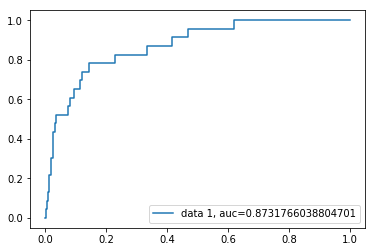

In [91]:
#calculating auc_score for plyaing more than 39 NHL games the median for Defensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
predictions = logisticRegr.predict(X_test)
y_pred_proba =  logisticRegr.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[514, 100],
       [  5,  18]], dtype=int64)

In [78]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
confusion_matrix(y_test, gnb_pred)

array([[549,  65],
       [ 11,  12]], dtype=int64)

0.7830689704007932


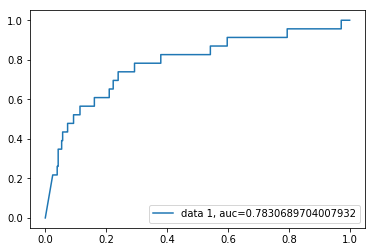

In [79]:
#naive bayes predictor
gnb_predictions = gnb.predict(X_test)
y_pred_prob_gnb =  gnb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_gnb)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [80]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
confusion_matrix(y_test, tree_pred)

array([[574,  40],
       [  9,  14]], dtype=int64)

0.8612802719161592


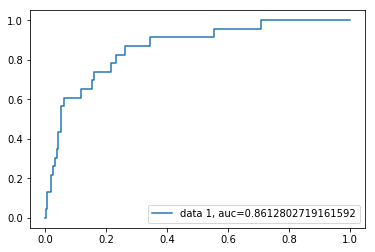

In [81]:
#random forest predictor
tree_predictions = tree.predict(X_test)
y_pred_prob_tree =  tree.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_tree)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_tree)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
confusion_matrix(y_test, dt_pred)

In [ ]:
#SVM
dt_predictions = dt.predict(X_test)
y_pred_prob_dt =  dt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob_dt)
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob_dt)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [114]:
#calculate SVM prediction probabilities
predictions = svc.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = svc.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_.25_nhl_pts_game_svc'] = predictions
draft_2018_df_def['>_.25_nhl_pts_game_svc'] = predictions_2018

In [88]:
#calculate random forest prediction probabilities
predictions = tree.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]

draft_df_def['>_.25_nhl_pts_game_tree'] = predictions
draft_2018_df_def['>_.25_nhl_pts_game_tree'] = predictions_2018

In [97]:
#calculate random forest prediction probabilities
predictions = gnb.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_.25_nhl_pts_game_gnb'] = predictions
draft_2018_df_def['>_.25_nhl_pts_game_gnb'] = predictions_2018

In [98]:
#calculate random forest prediction probabilities
predictions = logisticRegr.predict_proba(draft_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logisticRegr.predict_proba(draft_2018_df_def[['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL']])[:,1]
draft_df_def['>_.25_nhl_pts_game_log'] = predictions
draft_2018_df_def['>_.25_nhl_pts_game_log'] = predictions_2018

Text(0.5,0,'nhl_pts_per_gp')

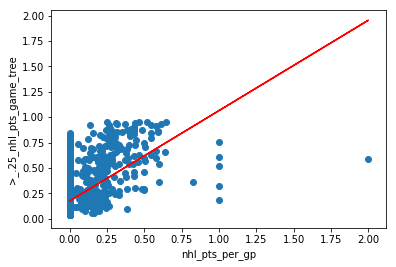

In [94]:
fig, ax = plt.subplots()
fit = np.polyfit(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'], deg=1)
ax.plot(draft_df_def['nhl_pts_per_gp'], fit[0] * draft_df_def['nhl_pts_per_gp'] + fit[1], color='red')
ax.scatter(draft_df_def['nhl_pts_per_gp'], draft_df_def['>_.25_nhl_pts_game_tree'])
plt.ylabel('>_.25_nhl_pts_game_tree')
plt.xlabel('nhl_pts_per_gp')

In [116]:
draft_2018_df_def['model_average'] = draft_2018_df_def[['>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', 
                                                        '>_.25_nhl_pts_game_tree', '>_.25_nhl_pts_game_svc'
]].mean(axis=1)
draft_2018_df_def = draft_2018_df_def.sort_values(['model_average'], ascending=False)


In [117]:
draft_2018_df_def[['Player', '>_.25_nhl_pts_game_svc',
                   '>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', 
                   '>_.25_nhl_pts_game_tree','model_average']].head(20)

,Player,>_.25_nhl_pts_game_svc,>_.25_nhl_pts_game_log,>_.25_nhl_pts_game_gnb,>_.25_nhl_pts_game_tree,model_average
103262,Bode Wilde,0.323111,0.960916,0.867203,0.847840,0.749768
120697,Ty Smith,0.056450,0.998072,1.000000,0.851501,0.726506
96756,Nicolas Beaudin,0.056525,0.994503,1.000000,0.827443,0.719618
78857,Quinn Hughes,0.244766,0.954696,1.000000,0.655620,0.713770
120553,Alexander Alexeyev,0.061830,0.925007,0.999836,0.726669,0.678335
88091,Rasmus Sandin,0.055236,0.978698,1.000000,0.654341,0.672069
120347,Calen Addison,0.056386,0.999124,1.000000,0.597971,0.663370
96573,Noah Dobson,0.058550,0.995730,1.000000,0.595251,0.662383
87814,Evan Bouchard,0.056602,0.999199,1.000000,0.572773,0.657144
102832,Rasmus Dahlin,0.050913,0.978938,0.999633,0.587955,0.654360


In [103]:
draft_df_def['model_average'] = draft_df_def[['>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', '>_.25_nhl_pts_game_tree'
]].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average'], ascending=False)

In [104]:
draft_df_def[['Player', '>_.25_nhl_pts_game_log', '>_.25_nhl_pts_game_gnb', '>_.25_nhl_pts_game_tree','model_average']].head(20)

,Player,>_.25_nhl_pts_game_log,>_.25_nhl_pts_game_gnb,>_.25_nhl_pts_game_tree,model_average
117017,Seth Jones,0.999400,1.000000,0.955023,0.984808
84573,Cody Ceci,0.997424,1.000000,0.956320,0.984581
81455,P.K. Subban,0.997300,1.000000,0.954402,0.983900
83946,Dougie Hamilton,0.997227,1.000000,0.950357,0.982528
111059,Cam Barker,0.999352,1.000000,0.941703,0.980352
83105,Ryan Ellis,0.999998,1.000000,0.939115,0.979704
114216,Tyson Barrie,0.998560,1.000000,0.936861,0.978473
82289,Michael Del Zotto,0.995180,1.000000,0.935304,0.976828
86190,Vince Dunn,0.995134,1.000000,0.933667,0.976267
116349,Derrick Pouliot,0.998030,1.000000,0.922196,0.973409


In [196]:
draft_rankings_2018 = draft_2018_df[['Player', '>_.25_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['>_.25_game_probs'], ascending=False)

In [197]:
draft_rankings_2018[(draft_rankings_2018['Player']=='Brady Tkachuk')]

,Player,>_.25_game_probs
67,Brady Tkachuk,0.010608
